Soft Voting Ensemble Performance (10-fold CV):
--------------------------------------------------------------------------------
Confusion Matrix:
[[243   1]
 [  1 243]]
Accuracy: 0.9959
Sensitivity: 0.9959
Specificity: 0.9959
AUC: 0.9997


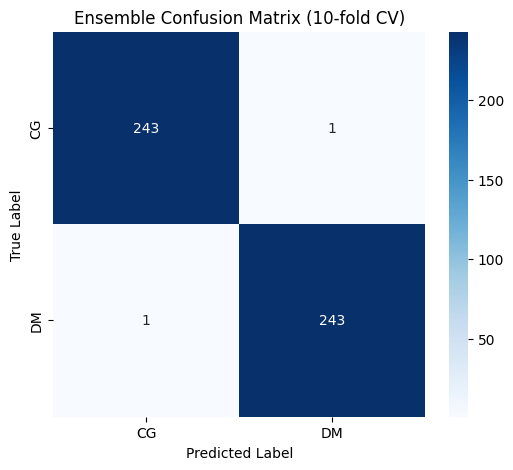

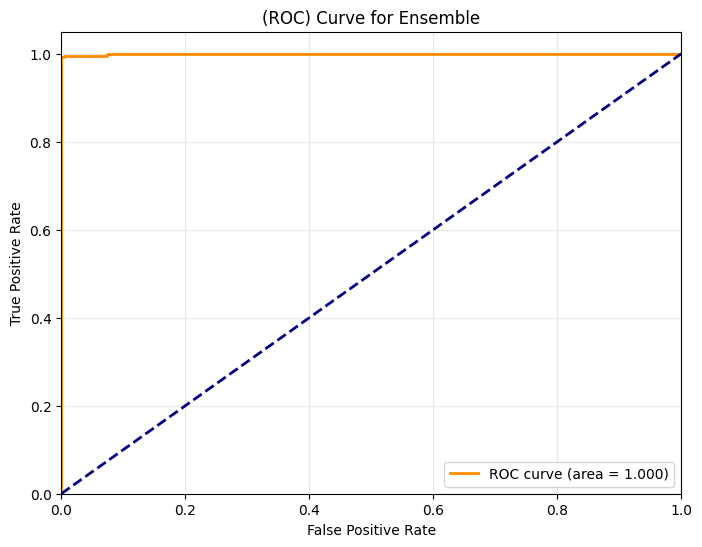

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load SIFT and SURF datasets
sift_path = '/content/modified_dataset_sift.xlsx'
surf_path = '/content/balanced_k=20_fullfoot.xlsx'

df_sift = pd.read_excel(sift_path)
df_surf = pd.read_excel(surf_path)

# Ensure labels are identical and in the same order
assert (df_sift['label'] == df_surf['label']).all(), "Labels/order mismatch!"

X_sift = df_sift.drop(columns=['label'])
X_surf = df_surf.drop(columns=['label'])
y = df_sift['label'].astype(int)

# Create pipelines for each feature set
pipe_sift = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, C=1, kernel='rbf', gamma='scale', random_state=42))
])

pipe_surf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, C=1, kernel='rbf', gamma='scale', random_state=42))
])

# Ensemble with soft voting
ensemble = VotingClassifier(
    estimators=[
        ('sift', pipe_sift),
        ('surf', pipe_surf)
    ],
    voting='soft'
)

# Stack features for VotingClassifier (concatenate SIFT and SURF features)
X_ensemble = np.hstack([X_sift, X_surf])

# 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(ensemble, X_ensemble, y, cv=cv, method='predict')
y_prob = cross_val_predict(ensemble, X_ensemble, y, cv=cv, method='predict_proba')[:, 1]

# ... [your previous code above] ...

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = accuracy_score(y, y_pred)

# Sensitivity and Specificity
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Print results
print("Soft Voting Ensemble Performance (10-fold CV):")
print("-" * 80)
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["CG", "DM"], yticklabels=["CG", "DM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Ensemble Confusion Matrix (10-fold CV)")
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Ensemble')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()
